In [ ]:
!pip install tensorflow==2.15.0


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.4 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.0
    Uninstalling ml-dtypes-0.4.0:
      Successfully uninstalled ml-dtypes-0.4.0
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: tensorboard
    Found existing installation

**Sepsis Environment**

In [4]:
import gym
from gym import spaces
import numpy as np
import pandas as pd
import tensorflow as tf

# Define the columns for state features and action features
state_cols = ['SOFA']  # Example state columns
action_cols = ['MaxVaso', 'Input4H']  # Medication columns

def predict_medication_effects(model, state, iv_fluid_dosage, vp_dosage, history):
    current_state = state[state_cols].values.reshape(1, -1)  # Shape: (1, 1) if 'SOFA' is the only state feature
    action = np.array([vp_dosage, iv_fluid_dosage]).reshape(1, -1)  # Shape: (1, 2)
    print (action)

    # Concatenate current state and action into a single input array
    model_input = np.concatenate([current_state, action], axis=1)  # Shape: (1, 3)

    # Concatenate historical cases with current input
    model_input = np.concatenate([model_input, history.reshape(1, -1)], axis=1)  # Shape: (1, 12)

    # Predict the next state
    state_change = model.predict(model_input)

    # Update the state with the predicted changes
    next_state = state.copy()
    next_state[state_cols] += state_change[0]

    return next_state, state_change[0][0]

class SepsisEnv(gym.Env):
    def __init__(self, dataset, model_path,action_history_input):
        super(SepsisEnv, self).__init__()
        self.dataset = dataset
        self.model = tf.keras.models.load_model(model_path)  # Load the trained model
        self.current_index = 0
        self.history_size = 3  # Size of history to maintain
        self.action_history = np.array(action_history_input)  # Initialize with example history
        self.action_space = spaces.Discrete(25)  # 5 x 5 = 25 possible actions

        # Calculate observation space size
        self.observation_size = len(state_cols) + len(action_cols) + len(state_cols) * self.history_size
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.observation_size,), dtype=np.float32)

    def reset(self):
        self.current_index = np.random.randint(0, len(self.dataset))
        self.action_history = np.array(action_history_input)  # Reset to example history
        return self._get_observation()

    def _get_observation(self):
        state = self.dataset.iloc[self.current_index][state_cols].values
        current_action = self.dataset.iloc[self.current_index][action_cols].values
        recent_history = self.action_history.flatten()  # Use action history

        return np.concatenate((state, current_action, recent_history))

    def step(self, action,time):
        state = self.dataset.iloc[self.current_index].copy()
        next_state = state.copy()

        dosage_list=self.decode_dosage(action)
        iv_fluid_dosage = dosage_list[1]
        vp_dosage = dosage_list[0]

        next_state, sofa_change = predict_medication_effects(self.model, next_state, iv_fluid_dosage, vp_dosage, self.action_history)

        current_sofa = self.action_history[2][0]
        next_sofa = sofa_change

        if next_sofa >=25 or next_sofa <=5 :
            done = True
        else:
            done = False

        reward = self.calculate_reward(current_sofa, next_sofa, done,time)

        # Update action history with current action (vp_dosage, iv_fluid_dosage)
        self.action_history = np.roll(self.action_history, -1, axis=0)  # Remove the oldest entry
        self.action_history[-1] = [sofa_change, vp_dosage, iv_fluid_dosage]  # Add new action at the end
        print("Action history:", self.action_history)

        print("Reward:", reward)
        print("Next SOFA:", next_sofa)
        print("Current SOFA:", current_sofa)



        self.current_index += 1

        print(done)
        # Prepare the observation to return
        observation = self._get_observation()

        # Return observation, reward, done status, and info dictionary
        info = {'predicted_sofa_state': next_state, 'action_applied': action}
        return observation, reward, done, info

    def calculate_reward(self, current_sofa, next_sofa, done, time):
        # Immediate reward based on SOFA score change
        if next_sofa < current_sofa:
            sofa_reward = (current_sofa - next_sofa) * 2
        elif next_sofa > current_sofa:
            sofa_reward = (next_sofa - current_sofa) * -2
        else:
            sofa_reward = 1  # Small reward for maintaining the SOFA score

        # Terminal reward based on episode end and SOFA score
        if done:
            if next_sofa <= 5:
                terminal_reward = 20  # High reward for achieving a low SOFA score at the end
                # Bonus reward for achieving the goal in fewer steps
                step_reward = (40 - time) / 40 * 10  # Adjust the multiplier as needed
            else:
                terminal_reward = -20 # Penalty for high SOFA score at the end
                step_reward = 0  # No step reward if the goal is not achieved
        else:
            terminal_reward = 0
            step_reward = 0  # No step reward if the episode is not done

        # Delayed reward: Smaller rewards for staying alive and progressing through time steps
        # survival_reward = (40 - time) / 40

        return sofa_reward + terminal_reward + step_reward  # + survival_reward (if implemented)




    def decode_dosage(self, dosage):
        vp_dosages = [0, 0.001, 0.01, 0.1, 1]
        iv_fluid_dosages = [0, 20, 60, 100, 200]

        flattened_array = [
                                    [0, 0], [0, 20], [0, 60], [0, 100], [0, 200],
                                    [0.001, 0], [0.001, 20], [0.001, 60], [0.001, 100], [0.001, 200],
                                    [0.01, 0], [0.01, 20], [0.01, 60], [0.01, 100], [0.01, 200],
                                    [0.1, 0], [0.1, 20], [0.1, 60], [0.1, 100], [0.1, 200],
                                    [1, 0], [1, 20], [1, 60], [1, 100], [1, 200]
                                ]


            # Function to access data by a single index (0-24)

        return flattened_array[dosage]



**DDQN Agent**

In [6]:
import random
from collections import deque
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

class DDQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.1
        self.learning_rate = 0.001
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.update_target_model()

    def _build_model(self):
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        print (action)

        return np.argmax(act_values[0])  # returns action

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = self.model.predict(state)

            if done:
                target[0][action] = reward
            else:
                t = self.target_model.predict(next_state)[0]
                target[0][action] = reward + self.gamma * np.amax(t)
            self.model.fit(state, target, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)


**Training Block**

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 37ms/step
22
[[0 0]]
1/1 [==============================] - 0s 54ms/step
Action history: {self.action_history}
Reward: {reward}
Next SOFA: {next_sofa}
Current SOFA: {current_sofa}
False
1/1 [==============================] - 0s 26ms/step
0
[[0 0]]
1/1 [==============================] - 0s 28ms/step
Action history: {self.action_history}
Reward: {reward}
Next SOFA: {next_sofa}
Current SOFA: {current_sofa}
False
1/1 [==============================] - 0s 26ms/step
0
[[ 1 60]]
1/1 [==============================] - 0s 35ms/step
Action history: {self.action_history}
Reward: {reward}
Next SOFA: {next_sofa}
Current SOFA: {current_sofa}
False
1/1 [==============================] - 0s 22ms/step
22
[[1 0]]
1/1 [==============================] - 0s 30ms/step
Action history: {self.action_history}
Reward: {reward}
Next SOFA: {next_sofa}
Current SOFA: {current_sofa}
False
1/1 [==============================] 

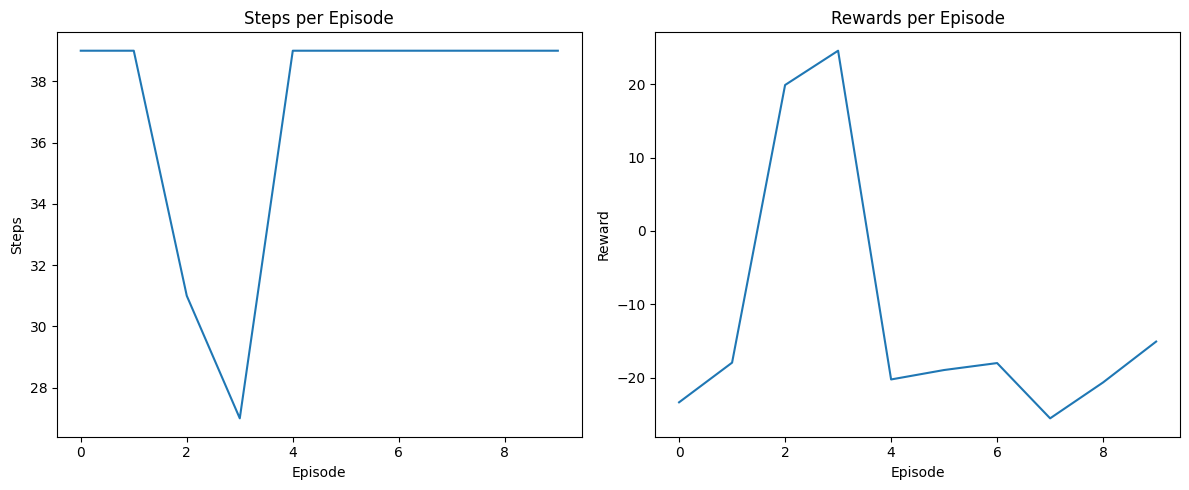

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

if __name__ == "__main__":
    action_history_input = []

    # Number of entries you want to input
    num_entries = 3

    # Loop to input values
    for i in range(num_entries):
        sofa_score = int(input(f"Enter SOFA score for entry {i + 1}: "))
        max_vaso = int(input(f"Enter Max Vaso dosage for entry {i + 1}: "))
        iv_fluid = int(input(f"Enter IV fluid dosage for entry {i + 1}: "))
        action_history_input.append([sofa_score, max_vaso, iv_fluid])
    # Load dataset
    dataset_path = '/content/drive/MyDrive/RL project/Dataset.csv'
    dataset = pd.read_csv(dataset_path)

    # Initialize environment and DDQN agent
    env = SepsisEnv(dataset=dataset, model_path='/content/drive/MyDrive/RL project/predict_state_model.keras', action_history_input=action_history_input)
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    print(state_size, action_size)

    agent = DDQNAgent(state_size, action_size)

    # Train the agent
    batch_size = 32
    episodes = 10  # Use the number of rows in the subset as episodes

    episode_rewards = []
    steps_per_episode = []

    for episode in range(episodes):
        state = env.reset()
        state = np.reshape(state, [2, state_size])
        total_reward = 0
        for time in range(40):
            action = agent.act(state)
            next_state, reward, done, info = env.step(action,time=time)
            next_state = np.reshape(next_state, [2, state_size])
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            if done:
                print(f"episode: {episode}/{episodes}, score: {time}, e: {agent.epsilon:.2}")
                break
            if len(agent.memory) > batch_size:
                agent.replay(batch_size)

        agent.update_target_model()

        episode_rewards.append(total_reward)
        steps_per_episode.append(time)

    agent.save("/content/drive/MyDrive/RL project/ddqn_new_model.h5")

    # Plot results
    plt.figure(figsize=(12, 5))

    # Plot steps per episode
    plt.subplot(1, 2, 1)
    plt.plot(range(episodes), steps_per_episode)
    plt.xlabel('Episode')
    plt.ylabel('Steps')
    plt.title('Steps per Episode')

    # Plot rewards per episode
    plt.subplot(1, 2, 2)
    plt.plot(range(episodes), episode_rewards)
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Rewards per Episode')

    plt.tight_layout()
    plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
